In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize, Bounds
import plotly.express as px
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
import time

## Создадим генераторы волатильности GARCH процессов с различными рычагами

In [2]:
# функция плотности нормального распредлеления (для ускорения подсчетов)
def norm(x, mean=0, sigma = 1):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mean)**2/(2*sigma**2))

# GARCH процесс с рычагом из TGARCH
def gen_t(x, nu):
    eps_tg = np.array([np.nan]*n)
    sigmalog2 = np.array([np.nan]*n)
    
    omega = x[0]
    beta = x[1]
    theta_plus = x[2]
    theta_minus = x[3]

    sigma0 = x[4]

    eps_tg[0] = sigma0*nu[0]
    sigmalog2[0] = np.log(sigma0**2)

    for t in range(1, n):
        sigmalog2[t] = omega + theta_plus*eps_tg[t-1]*(eps_tg[t-1]>=0) - theta_minus*eps_tg[t-1] \
        *(eps_tg[t-1]<0) + beta*sigmalog2[t-1]
        eps_tg[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
    return np.sqrt(np.exp(sigmalog2))

# GARCH процесс с рычагом из EGARCH
def gen_e(x, nu):
    eps_egarch = np.array([np.nan]*n)
    sigmalog2 = np.array([np.nan]*n)

    w = x[0]
    a = x[1]
    b = x[2]
    theta = x[3]
    sigma0 = x[4]

    eps_egarch[0] = sigma0*nu[0]
    sigmalog2[0] = np.log(sigma0**2)

    for t in range(1, n):
        sigmalog2[t] = w + a*(theta*nu[t-1] + ( abs(nu[t-1])-math.sqrt(2/np.pi) )) + b*sigmalog2[t-1]
        eps_egarch[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
    return np.sqrt(np.exp(sigmalog2))

## Функции правдоподобия GARCH процессов с рычагом

In [3]:
# GARCH процесс с рычагом из EGARCH
def l_e(x, y):
    n = len(y)
    w = x[0]
    a = x[1]
    b = x[2]
    theta = x[3]
    eps = y 
    sigma0 = x[4]
    sigmalog2 = np.array([np.nan]*n)
    sigmalog2[0] = np.log(sigma0**2)
    nu = np.array([np.nan]*n)
    nu[0] =eps[0]/np.sqrt(np.exp(sigmalog2[0]))
    for t in range(1,n):
        sigmalog2[t] = w + a*(theta*nu[t-1] + ( abs(nu[t-1])-math.sqrt(2/np.pi) )) + b*sigmalog2[t-1]
        nu[t] = eps[t]/np.sqrt(np.exp(sigmalog2[t]))
    L = np.array([np.nan]*n)
    sigma = np.sqrt(np.exp(sigmalog2))
    for t in range(n):
        L[t] = norm(eps[t], 0, sigma[t])
    l = np.sum(np.log(L))
    return -l

# GARCH процесс с рычагом из TGARCH
def l_t(x, y):
    n = len(y)
    omega = x[0]
    beta = x[1]
    theta_plus = x[2]
    theta_minus = x[3]
    eps = y 
    sigma0 = x[4]
    sigmalog2 = np.array([np.nan]*n)
    sigmalog2[0] = np.log(sigma0**2)
    for t in range(1,n):
        sigmalog2[t] = omega + theta_plus*eps[t-1]*(eps[t-1]>=0) - theta_minus*eps[t-1]*(eps[t-1]<0) + beta*sigmalog2[t-1]
    L = np.array([np.nan]*n)
    st = time.time()
    sigma = np.sqrt(np.exp(sigmalog2))
    for t in range(n):
        L[t] = norm(eps[t], 0, sigma[t])
    l = np.sum(np.log(L))
    return -l

## Симуляция данных 

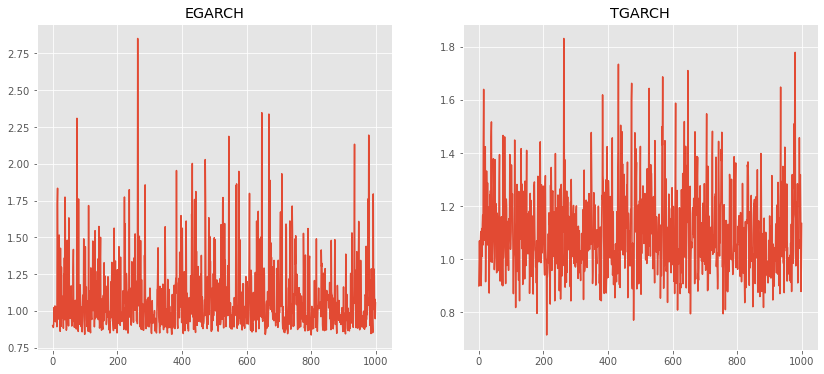

In [4]:
np.random.seed(42)
n = 10**3
x_real_e = np.array([0.1,0.5, 0.2, -0.5,0.9])
x_real_t = np.array([0.1,0.2,-0.2, 0.3,0.9])
nu = np.random.normal(0,1,n)

sigma_e = gen_e(x_real_e, nu)
sigma_t = gen_t(x_real_t, nu)

fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.lineplot(y=sigma_e, x=list(range(n)),ax=ax[0])
ax[0].set_title('EGARCH')
sns.lineplot(y=sigma_t, x=list(range(n)), ax=ax[1]);
ax[1].set_title('TGARCH');

## Приближение GARCH процесса к данному с помощью KL дивергенции:

Обозначим за $f_t^i(x)$  функцию условную плотности распределения $\varepsilon_t|\mathcal{F}_{t-1}$ 

Будем приближать условное распределение $\varepsilon_t$ в каждый момент времени t.

1)
$$
\sum_{t=1}^T KL(f^e_t(x) || f^\tau_t(x|\theta)) = \sum_t^T\int_{-\infty}^{+\infty} f^e_t(x)log(\frac{f^e_t(x)}{f^\tau_t(x|\theta)})dx \to min_{\theta}
$$

Выделим часть, независящую от $\theta$:

2)
$$
    C_t = \int_{-\infty}^{+\infty} f^e_t(x)log({f^e_t(x)}) = \int_{-\infty}^{+\infty} \frac{1}{\sqrt{2\pi}\sigma_t^e} e^{-\frac{x^2}{2(\sigma_t^e)^2}}log(\frac{1}{\sqrt{2\pi}\sigma_t^e} e^{-\frac{x^2}{2(\sigma_t^e)^2}})dx = -\frac{1}{2}(log(2\pi)+1) - log\sigma_t^e
$$

Перепишем (1):
$$
\sum_{t=1}^T [C_t - \int_{-\infty}^{+\infty} f^e_t(x)log({f^\tau_t(x|\theta)})dx] \to min_\theta
$$

Распишем интеграл:

$$
\int_{-\infty}^{+\infty} f^e_t(x)log({f^\tau_t(x|\theta)})dx =  -\frac{1}{2}log(2\pi) - log\sigma_t^\tau - \frac{1}{2\sqrt{2\pi}\sigma_t^e(\sigma_t^\tau)^2}\int_{-\infty}^{+\infty} x^2e^{-\frac{x^2}{2(\sigma_t^e)^2}}dx = 
-\frac{1}{2}log(2\pi) - log\sigma_t^\tau - \frac{\sqrt{2\pi}(\sigma_t^e)^2}{2\sqrt{2\pi}\sigma_t^e(\sigma_t^\tau)^2} = 
-\frac{1}{2}log(2\pi) - log\sigma_t^\tau - \frac{1}{2}(\frac{\sigma_t^e}{\sigma_t^\tau})^2
$$

Итоговая "функция потерь":

$$
L = \sum_{t=1}^T [-\frac{1}{2} - log\sigma_t^e + log\sigma_t^\tau + \frac{1}{2}(\frac{\sigma_t^e}{\sigma_t^\tau})^2] \to min_\theta
$$

где:

$
\sigma_t^\tau = \sigma_t^\tau(\theta) \text{  (задается соответствующим уравнением GARCH процесса)}
$

$
\sigma_t^e - \text{фиксирована  } \forall t=1,\dots, T \text{  (задается соответствующим уравнением GARCH процесса)}
$


## Посмотрим на "устойчивость" метрики в зависимсти от реализации шоков

In [6]:
# KL дивергенция (приближение GARCH с рычагом TGARCH к GARCH с рычагом EGARCH)
def L_experiments(x0, x_e, nu):
    sigma_e = gen_e(x_e, nu)
    sigma_t = gen_t(x0, nu)
    L = np.sum(-1/2 - np.log(sigma_e)+np.log(sigma_t)+0.5*(sigma_e/sigma_t)**2)
    return L     

In [7]:
num_exper = 10**4
exper = []
for i in tqdm(range(num_exper)):
    n = 10**3
    nu = np.random.normal(0,1,n)
    exper.append(L_experiments(x_real_t, x_real_e, nu))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
print('Стандартное отклонение: ',np.std(exper))
print('Среднее: ',np.mean(exper))

Стандартное отклонение:  1.3807851402441476
Среднее:  21.380929288486332


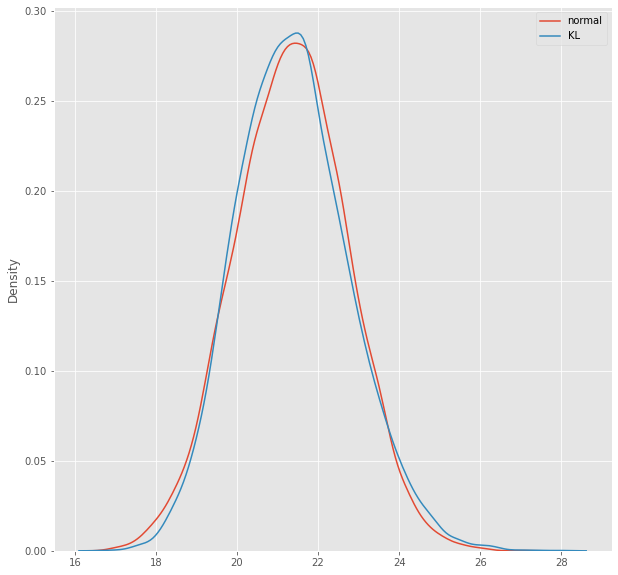

In [12]:
fig. ax = plt.subplots(figsize=(10,10))
x = np.random.normal(np.mean(exper),np.std(exper), len(exper))
sns.kdeplot(x, legend='normal')
sns.kdeplot(exper,legend='KL')
plt.legend(['normal', 'KL']);

## Реализуем метрику для произвольных процессов

In [14]:
def L(x0, sigma_e, nu, gen_t, is_aggregate = True):
    sigma_t = gen_t(x0, nu)
    kl = -1/2 - np.log(sigma_e)+np.log(sigma_t)+0.5*(sigma_e/sigma_t)**2
    if is_aggregate == True:
         return np.sum(kl)
    else:
        return kl   

## Проверим корректность алгоритма

In [22]:
bnds = Bounds(-2,2)
opts = {'maxiter' : 10000}#, 'verbose' : 3} 
res1_trivial = minimize(L, x0=x0, args=(sigma_e, nu, gen_e), method='trust-constr', bounds=bnds, options=opts)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [21]:
res1_trivial

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 235
      cg_stop_cond: 4
            constr: [array([ 0.09999999,  0.5       ,  0.2       , -0.5       ,  0.89999994])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 5.278632164001465
               fun: 9.880984919163893e-15
              grad: array([ 1.22934580e-06,  7.52508643e-07,  1.60187483e-07, -4.54485416e-07,
       -1.56462193e-07])
               jac: [<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([ 8.17579808e-07,  4.69355471e-07,  1.05853144e-07, -2.83606922e-07,
       -7.98346833e-08])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 690
              nhev: 0
               nit: 84
             niter: 84
      

In [28]:
print('Реальные значения параметров: ',*x_real_e)
print('Оцененные значения параметров: ')
print(*res1_trivial.x)
print('Значение метрики: ', res1_trivial.fun)

Реальные значения параметров:  0.1 0.5 0.2 -0.5 0.9
Оцененные значения параметров: 
0.09999999445074326 0.49999999638591236 0.1999999980716103 -0.49999999800976447 0.8999999387153641
Значение метрики:  9.880984919163893e-15


## Приблизим GARCH с рычагом TGARCH к GARCH с рычагом EGARCH

In [29]:
np.random.seed(42)
x0 = np.array([0.1,0.2,-0.2, 0.3,0.9])
nu = np.random.normal(0,1, len(sigma_e))

In [30]:
L(x0, sigma_e, nu, gen_t)

20.766895977497903

In [17]:
bnds = Bounds(-2,2)
opts = {'maxiter' : 10000}#, 'verbose' : 3} 
res1 = minimize(L, x0=x0, args=(sigma_e, nu, gen_t), method='trust-constr', bounds=bnds, options=opts)

In [18]:
res1

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 224
      cg_stop_cond: 4
            constr: [array([-0.25098791, -0.01014846,  0.22183611,  0.65291121,  0.89881043])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 8.933735370635986
               fun: 1.3597984421345015
              grad: array([-2.38418579e-07,  1.04308128e-07,  1.19209290e-07,  2.08616257e-07,
        0.00000000e+00])
               jac: [<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-1.56587561e-07,  6.95300337e-08,  7.86385260e-08,  1.23653304e-07,
        5.93368723e-10])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 582
              nhev: 0
               nit: 75
             niter: 75
         

In [32]:
print('Оцененные параметры: ',*res1.x)
print('Значение метрики: ', res1.fun)

Оцененные параметры:  -0.2509879092908266 -0.01014846075383171 0.22183611138737952 0.6529112128797655 0.8988104293976139
Значение метрики:  1.3597984421345015


## Сравнение стандартного отклонения

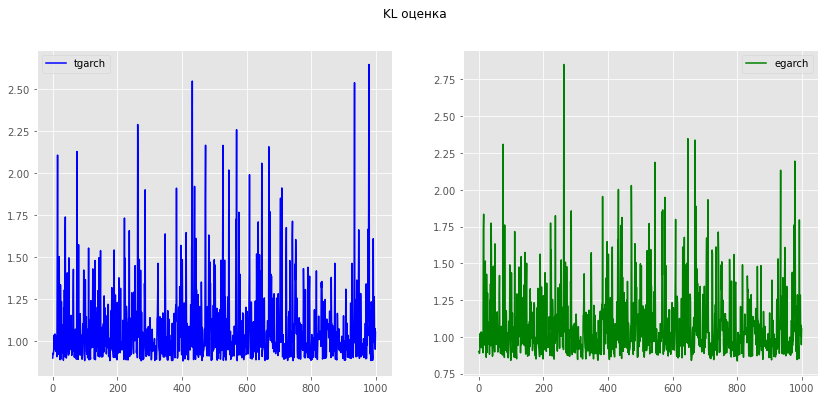

In [33]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
fig.suptitle('KL оценка')
sns.lineplot(y=gen_t(res1.x, nu), x = list(range(n)),ax = ax[0], color = 'blue')
ax[0].legend(['tgarch'])
sns.lineplot(y=sigma_e, x = list(range(n)),ax=ax[1], color = 'green')
ax[1].legend(['egarch']);

## Сравнение процессов $\varepsilon_t$

In [34]:
def gen_t_eps(x, nu):
    eps_tg = np.array([np.nan]*n)
    sigmalog2 = np.array([np.nan]*n)
    
    omega = x[0]
    beta = x[1]
    theta_plus = x[2]
    theta_minus = x[3]

    sigma0 = x[4]

    eps_tg[0] = sigma0*nu[0]
    sigmalog2[0] = np.log(sigma0**2)

    for t in range(1, n):
        sigmalog2[t] = omega + theta_plus*eps_tg[t-1]*(eps_tg[t-1]>=0) - theta_minus*eps_tg[t-1] \
        *(eps_tg[t-1]<0) + beta*sigmalog2[t-1]
        eps_tg[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
    return eps_tg

def gen_e_eps(x, nu):
    eps_egarch = np.array([np.nan]*n)
    sigmalog2 = np.array([np.nan]*n)

    w = x[0]
    a = x[1]
    b = x[2]
    theta = x[3]
    sigma0 = x[4]

    eps_egarch[0] = sigma0*nu[0]
    sigmalog2[0] = np.log(sigma0**2)

    for t in range(1, n):
        sigmalog2[t] = w + a*(theta*nu[t-1] + ( abs(nu[t-1])-math.sqrt(2/np.pi) )) + b*sigmalog2[t-1]
        eps_egarch[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
    return eps_egarch

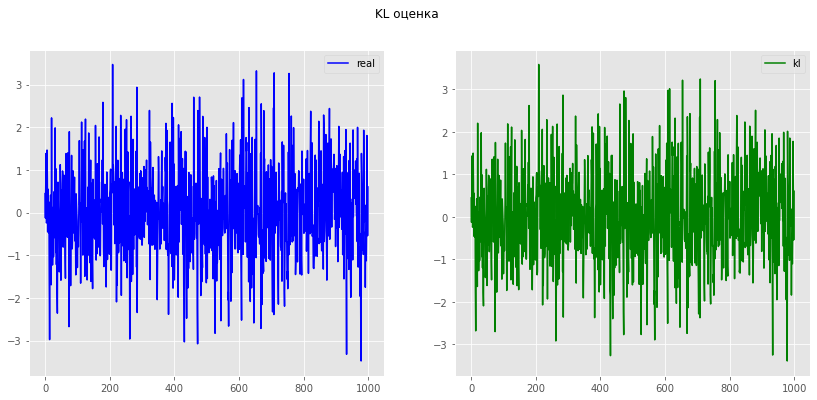

In [35]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
fig.suptitle('KL оценка')
sns.lineplot(y = gen_e_eps(x_real_e, nu), x = range(len(nu)),ax=ax[0], color = 'blue')
sns.lineplot(y = gen_t_eps(res1.x, nu), x = range(len(nu)),ax=ax[1], color='green')
ax[0].legend(['real'])
ax[1].legend(['kl']);

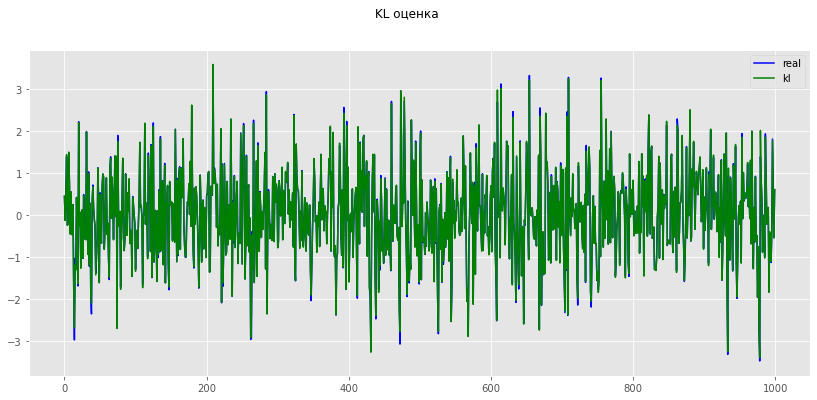

In [36]:
fig, ax = plt.subplots(figsize = (14,6))
fig.suptitle('KL оценка')
sns.lineplot(y = gen_e_eps(x_real_e, nu), x = range(len(nu)),ax=ax, color = 'blue')
sns.lineplot(y = gen_t_eps(res1.x, nu), x = range(len(nu)),ax=ax, color='green')
ax.legend(['real','kl']);

In [39]:
## MSE процессов
np.sum((gen_e_eps(x_real_e, nu) - gen_t_eps(res1.x, nu))**2)/n

0.002553368363913867

## Оценка параметров с помощью ММП

In [40]:
eps_e = gen_e_eps(x_real_e, nu)

In [41]:
bnds = Bounds(-2,2)
opts = {'maxiter' : 10000}#, 'verbose' : 3} 
res_ll = minimize(l_t, x0=x0, args=(eps_e), method='trust-constr', bounds=bnds, options=opts)

C:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [42]:
res_ll

 barrier_parameter: 2.048000000000001e-09
 barrier_tolerance: 2.048000000000001e-09
          cg_niter: 343
      cg_stop_cond: 2
            constr: [array([-0.28544823, -0.21185778,  0.22798516,  0.64063656,  0.49084771])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 17.926032543182373
               fun: 1449.3495393866517
              grad: array([-1.52587891e-05, -1.52587891e-05,  1.52587891e-05,  1.52587891e-05,
        0.00000000e+00])
               jac: [<5x5 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([-9.96269151e-06, -1.00576717e-05,  1.00393517e-05,  9.05837975e-06,
        3.34225179e-10])
           message: '`xtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 996
              nhev: 0
               nit: 108
             niter: 108
      

In [43]:
#Рассчитаем показатель для оценённых параметров
L(res_ll.x, sigma_e,nu, gen_t)

4.531484959458296

In [44]:
#минимальное значение показателя
L(res1.x, sigma_e, nu, gen_t)

1.3597984421345015

# Имплементация нового рычага

In [46]:
# реализация рычагов в виде отдельных функций
def e_leverage(theta,nu): # рычаг из EGARCH
    return theta*nu + ( abs(nu)-np.sqrt(2/np.pi) )
def t_leverage(theta_plus,theta_minus, eps): # рычаг из TGARCH
    return theta_plus*eps*(eps>=0) - theta_minus*eps *(eps<0)
def gjr_leverage(theta_gjr1, theta_gjr2,eps): # рычаг из GJRGARCH
    return theta_gjr1*eps**2 +theta_gjr2 * (eps<0)*eps**2
def poly_leverage(theta1, theta2, nu): # полиномиальный рычаг
    return theta1*nu + theta2*(nu**2-1)

##  Линейная комбинация рычагов

In [54]:
# Генератор (аналогично представленным выше)
def gen_lin(x, nu):
    eps = np.array([np.nan]*n)
    sigmalog2 = np.array([np.nan]*n)
    
    omega = x[0]
    a_e = x[1]
    a_t = x[2]
    a_gjr = x[3]
    a_poly = x[4]
    beta = x[5]
    theta = x[6]
    theta_plus,theta_minus = x[7],x[8]
    theta_gjr1,theta_gjr2 = x[9], x[10]
    theta1, theta2 = x[11],x[12]
    sigma0 = x[13]
    eps[0] = sigma0*nu[0]
    sigmalog2[0] = np.log(sigma0**2)

    for t in range(1, n):
        sigmalog2[t] = omega + a_e*e_leverage(theta, nu[t-1]) + a_t*t_leverage(theta_plus,theta_minus, eps[t-1])\
        +a_gjr*gjr_leverage(theta_gjr1, theta_gjr2, eps[t-1]) + a_poly*poly_leverage(theta1, theta2, nu[t-1]) \
        + beta*sigmalog2[t-1]
        eps[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
    return np.sqrt(np.exp(sigmalog2))
    

In [55]:
x_real =[0.118, 0.24, 0.119, 0.286, 0.225, 0.441, -0.024, 0.012, -0.28 ,0.023, 0.045, 0.015, 0.658, 0.9]

In [56]:
np.random.seed(42)
n = 1000
nu = np.random.normal(0,1, n)

In [57]:
sigma = gen_lin(x_real, nu)

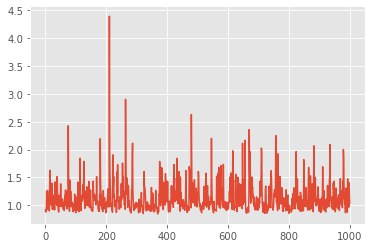

In [59]:
sns.lineplot(x=range(n), y = sigma);